In [115]:
import pandas as pd
import os
import seaborn as sns
#from skbio.diversity import alpha_diversity
#from skbio.diversity import beta_diversity
#from skbio import TreeNode
from io import StringIO
#from skbio.stats.ordination import pcoa
from skbio.stats.composition import ancom
import math
from skbio.stats.composition import multiplicative_replacement

In [2]:
import cx_Oracle

SERVER = 'dboracle.itk.ppke.hu'
PORT = 1521
SERVICE = 'rsc.itk.ppke.hu'
USER = 'metagenome'
PASSWORD = 'LrJPRUS73r84'

class Connection():

    def __init__(self):
        dsn_tns = cx_Oracle.makedsn(SERVER, PORT, service_name=SERVICE)
        self.connection = cx_Oracle.connect(USER, PASSWORD, dsn_tns)

    def get_connection(self):
        return self.connection

    def select(self, sql):
        return pd.read_sql(sql, con=self.connection)

con = Connection()

In [3]:
def get_read_count(dataset_name, sample_id):
    SQL = """
    select
        DATASET_NAME,
        NCBI_ACCESSION,
        NUMBER_READS
    from METADATA
    where dataset_name = '{DATASET_NAME}'
    and NCBI_ACCESSION like '%{SAMPLE_ID}%'
    """.replace("{DATASET_NAME}",dataset_name).replace("{SAMPLE_ID}",sample_id)
    df = con.select(SQL)
    return int(df.NUMBER_READS)

In [4]:
get_read_count("RampelliS_2015", "SRR1930123")

77841428

In [7]:
path_kraken = '//gfs/data/curated_metagenomes_kraken2/'

files_kraken = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_kraken):
    for file in f:
        if '.csv' in file:
            files_kraken.append(os.path.join(path_kraken, file))
print(files_kraken)

['//gfs/data/curated_metagenomes_kraken2/RampelliS_2015.csv', '//gfs/data/curated_metagenomes_kraken2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_kraken2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/Heitz-BuschartA_2016.csv', '//gfs/data/curated_metagenomes_kraken2/KarlssonFH_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LeChatelierE_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LiuW_2016.csv', '//gfs/data/curated_metagenomes_kraken2/LomanNJ_2013.csv', '//gfs/data/curated_metagenomes_kraken2/Obregon-TitoAJ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/QinJ_2012.csv', '//gfs/data/curated_metagenomes_kraken2/QinN_2014.csv', '//gfs/data/curated_metagenomes_kraken2/SchirmerM_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VatanenT_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_kraken2/XieH_2016.csv', '//gfs/data/curated_metagenomes_kraken2

In [47]:
path_metaphlan = '//gfs/data/curated_metagenomes_metaphlan2/'

files_metaphlan = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_metaphlan):
    for file in f:
        if '.csv' in file:
            files_metaphlan.append(os.path.join(path_metaphlan, file))
print(files_metaphlan)

['//gfs/data/curated_metagenomes_metaphlan2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_metaphlan2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv']


In [9]:
def get_data_for_sample(path_to_file):
    dataset = path_to_file.split('/')[-1]
    df = pd.read_csv(path_to_file, delimiter = ',')
    df['Dataset'] = dataset
    df["Name"] = [n.strip() for n in df["Name"]]
    return df

In [10]:
class WrongRank(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

In [142]:
def get_table_and_grouping(df_name, table_files, column_to_group='STUDY_CONDITION', rank='F', 
                           use_percent= True, percent=30, group=None):

    for file in table_files:
        if df_name in file:
            index = table_files.index(file)
            
    print(table_files[index])
    df = get_data_for_sample(table_files[index])
    
    print(df.head())
    
    df_2 = df.loc[df['Rank'] == rank]
    if len(df_2) == 0:
        raise WrongRank(rank)
    
    df_2 = df_2[['Sample_ID', 'Name', 'Abundance', column_to_group]]
    df_2 = df_2.loc[[i == i for i in df_2[column_to_group]]]
    print(df_2.columns)
    if group is not None:
        df_2[column_to_group] = [group if group in v else "Control" for v in df_2[column_to_group]]
    
    print("Groups:", df_2[column_to_group].drop_duplicates())
                   
    table = df_2.pivot(index='Sample_ID', columns='Name', values='Abundance')
    
    # Dropping sparse columns
    if use_percent:
        counts = {}
        to_drop = []
        for column in table.columns:
            counts[column] = table[column].loc[table[column].notnull()].count() + table[column].loc[table[column] != 0].count()
            
            if counts[column] < table.shape[1]/100*percent:
                to_drop.append(column)
        table = table.drop(columns = to_drop)
    
    print("Shape of table:", table.shape)
    
    # Handling remaining Nan values and zero values: pseudo-count = 1, 
    #abundance calcuated: 1/read_count*100
    
    def get_abudance_percent_for_zeros(row):
        read_count = get_read_count(df_name, row.name)
        for col in row.keys():
            if math.isnan(row[col]) or row[col] == 0:
                #row[col] = 1/read_count*100
                row[col] = 1
            else:
                row[col] = row[col]/100*read_count + 1
        return row    
    
    table = table.fillna(0)
    #table = table.apply(get_abudance_percent_for_zeros, axis=1)
    table_repl = pd.DataFrame(multiplicative_replacement(table.values),
                      index=table.index,
                      columns=table.columns)
    
    # NOT GOOD: 
    #table = table.fillna(1)
    
    grouping = df_2[['Sample_ID', column_to_group]].drop_duplicates()
    grouping.index = grouping["Sample_ID"]
    grouping = grouping.drop(columns = ["Sample_ID"])
    
    grouping_ser = grouping[column_to_group]
    results = ancom(table_repl, grouping_ser)
    return results

In [23]:
def analyse(dataset_name, table_files, column_to_group = "STUDY_CONDITION", rank='F', 
            use_percent = False, percent=30, group=None):
    result_df, percentile_df = get_table_and_grouping(dataset_name, table_files,
                                                  column_to_group,
                                                  rank, use_percent, percent, group)
    differences = list(result_df.loc[[i for i in result_df["Reject null hypothesis"]]].index)
    print("------------------- RESULTS ------------------- ")
    df_list = []
    for d in differences:
        print(percentile_df[50.0].loc[d])
        df = pd.DataFrame(percentile_df[50.0].loc[d])
        df_list.append(df.transpose())
    try:
        df_dataset = pd.concat(df_list)
    except:
        return differences
    
    unpivot = pd.DataFrame(df_dataset.unstack(level=1))
    unpivot = unpivot.reset_index()
    unpivot["Abundance"] = unpivot[0]
    unpivot["Name"] = unpivot['level_1']
    unpivot = unpivot.drop(columns=[0, 'level_1'])
    
    g = sns.catplot(x="Name", y="Abundance", hue="Group", data=unpivot,
                kind="bar", palette="muted")
    return result_df, percentile_df, unpivot

//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank                 Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    U         unclassified      70.88   
1           1  ERR688526  FengQ_2015.csv    R                 root      29.12   
2           2  ERR688526  FengQ_2015.csv   R1   cellular organisms      29.11   
3           3  ERR688526  FengQ_2015.csv    D             Bacteria      29.05   
4           4  ERR688526  FengQ_2015.csv   D1  Terrabacteria group      25.38   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CA

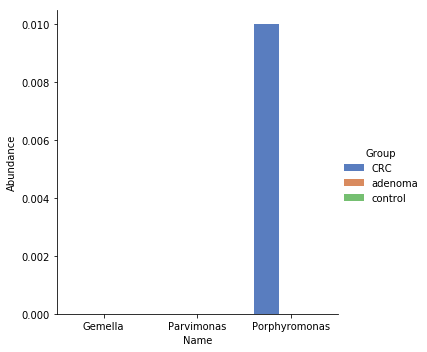

In [51]:
x = df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_kraken,
                     column_to_group = "STUDY_CONDITION", rank='G', use_percent = True, percent=5)

//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1

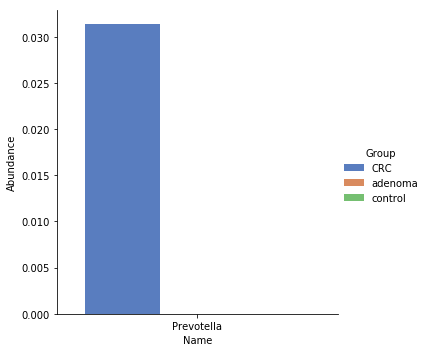

In [52]:
x = df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_metaphlan,
                     column_to_group = "STUDY_CONDITION", rank='g', use_percent = True, percent=5)

//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank                 Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    U         unclassified      70.88   
1           1  ERR688526  FengQ_2015.csv    R                 root      29.12   
2           2  ERR688526  FengQ_2015.csv   R1   cellular organisms      29.11   
3           3  ERR688526  FengQ_2015.csv    D             Bacteria      29.05   
4           4  ERR688526  FengQ_2015.csv   D1  Terrabacteria group      25.38   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CA

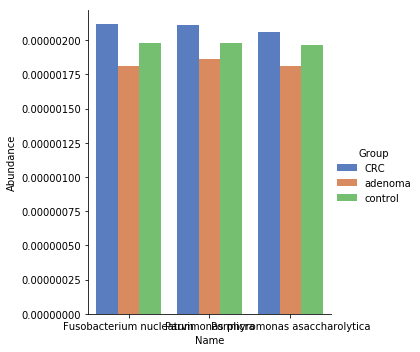

In [54]:
x = df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_kraken,
                     column_to_group = "STUDY_CONDITION", rank='S', use_percent = True, percent=2)

//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1

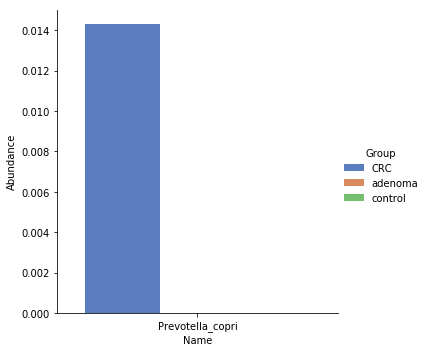

In [55]:
x = df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_metaphlan,
                     column_to_group = "STUDY_CONDITION", rank='s', use_percent = True, percent=2)

//gfs/data/curated_metagenomes_kraken2/ChngKR_2016.csv
   Unnamed: 0   Sample_ID          Dataset Rank                Name  \
0           0  SRR1950714  ChngKR_2016.csv    U        unclassified   
1           1  SRR1950714  ChngKR_2016.csv    R                root   
2           2  SRR1950714  ChngKR_2016.csv   R1  cellular organisms   
3           3  SRR1950714  ChngKR_2016.csv    D           Eukaryota   
4           4  SRR1950714  ChngKR_2016.csv   D1        Opisthokonta   

   Abundance STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY DISEASE  AGE  \
0      17.79         control      skin      Sub1     IDN    none   30   
1      82.21         control      skin      Sub1     IDN    none   30   
2      82.14         control      skin      Sub1     IDN    none   30   
3      68.55         control      skin      Sub1     IDN    none   30   
4      68.55         control      skin      Sub1     IDN    none   30   

  AGE_CATEGORY  
0        adult  
1        adult  
2        adult  
3        ad

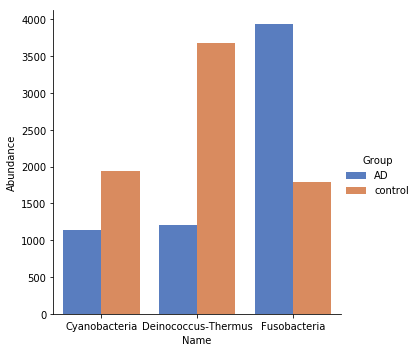

In [67]:
df_dataset_ChngKR_2016_kraken = analyse("ChngKR_2016", table_files = files_kraken,
                     column_to_group = "STUDY_CONDITION", rank='P')

//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank                 Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    U         unclassified      70.88   
1           1  ERR688526  FengQ_2015.csv    R                 root      29.12   
2           2  ERR688526  FengQ_2015.csv   R1   cellular organisms      29.11   
3           3  ERR688526  FengQ_2015.csv    D             Bacteria      29.05   
4           4  ERR688526  FengQ_2015.csv   D1  Terrabacteria group      25.38   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CA

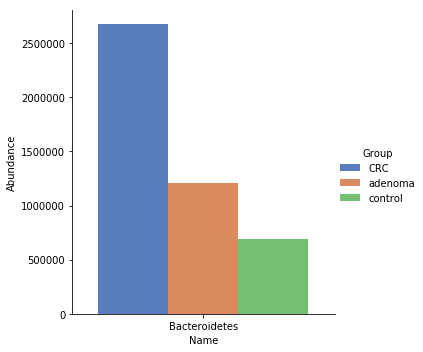

In [68]:
df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_kraken,
                     column_to_group = "STUDY_CONDITION", rank='P')

//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1

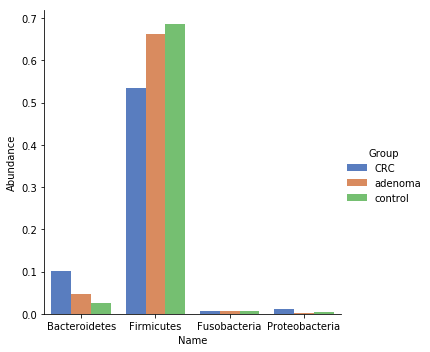

In [138]:
df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_metaphlan,
                     column_to_group = "STUDY_CONDITION", rank='p')

//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank                 Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    U         unclassified      70.88   
1           1  ERR688526  FengQ_2015.csv    R                 root      29.12   
2           2  ERR688526  FengQ_2015.csv   R1   cellular organisms      29.11   
3           3  ERR688526  FengQ_2015.csv    D             Bacteria      29.05   
4           4  ERR688526  FengQ_2015.csv   D1  Terrabacteria group      25.38   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CA

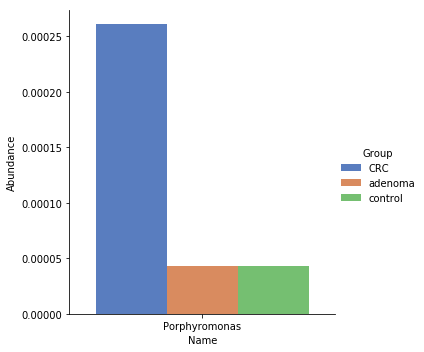

In [144]:
df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_kraken,
                     column_to_group = "STUDY_CONDITION", rank='G', use_percent= True, percent=10)

//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1

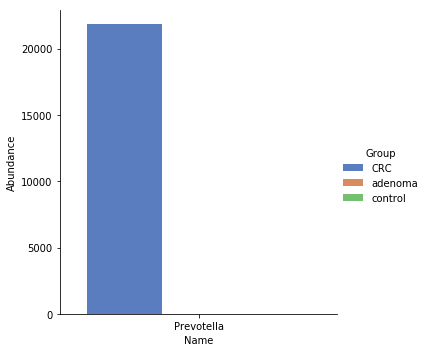

In [77]:
df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_metaphlan,
                     column_to_group = "STUDY_CONDITION", rank='g', use_percent= True, percent=5)

//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank                 Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    U         unclassified      70.88   
1           1  ERR688526  FengQ_2015.csv    R                 root      29.12   
2           2  ERR688526  FengQ_2015.csv   R1   cellular organisms      29.11   
3           3  ERR688526  FengQ_2015.csv    D             Bacteria      29.05   
4           4  ERR688526  FengQ_2015.csv   D1  Terrabacteria group      25.38   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CA

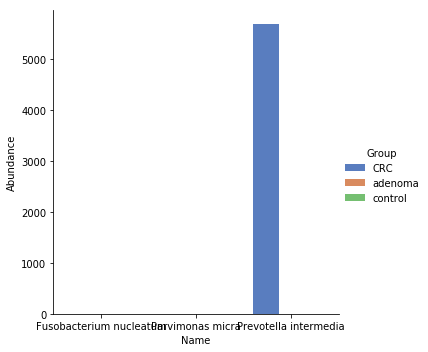

In [91]:
df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_kraken,
                     column_to_group = "STUDY_CONDITION", rank='S', use_percent = True, percent=2.65555)

//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1

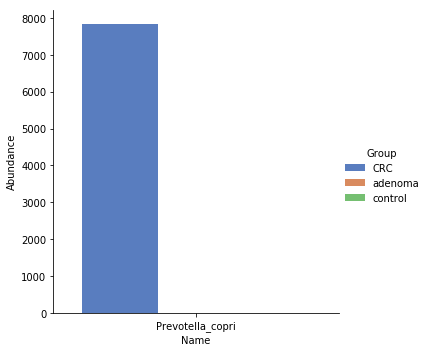

In [79]:
df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_metaphlan,
                     column_to_group = "STUDY_CONDITION", rank='s', use_percent = True, percent=2)

//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank                 Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    U         unclassified      70.88   
1           1  ERR688526  FengQ_2015.csv    R                 root      29.12   
2           2  ERR688526  FengQ_2015.csv   R1   cellular organisms      29.11   
3           3  ERR688526  FengQ_2015.csv    D             Bacteria      29.05   
4           4  ERR688526  FengQ_2015.csv   D1  Terrabacteria group      25.38   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CA

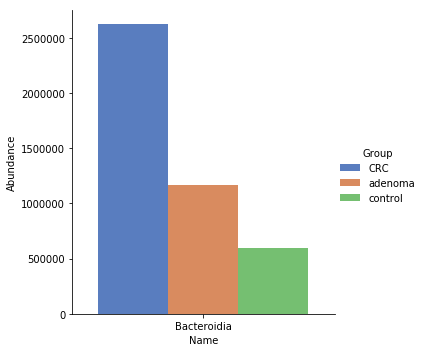

In [106]:
df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_kraken,
                     column_to_group = "STUDY_CONDITION", rank='C', use_percent = True, percent=30)

//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank                 Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    U         unclassified      70.88   
1           1  ERR688526  FengQ_2015.csv    R                 root      29.12   
2           2  ERR688526  FengQ_2015.csv   R1   cellular organisms      29.11   
3           3  ERR688526  FengQ_2015.csv    D             Bacteria      29.05   
4           4  ERR688526  FengQ_2015.csv   D1  Terrabacteria group      25.38   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CA

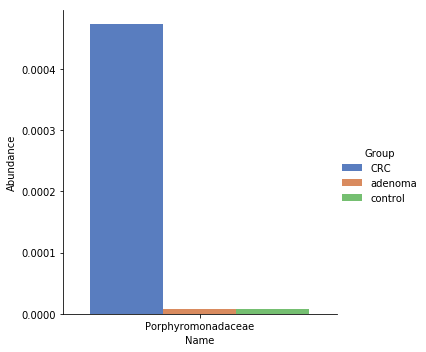

In [145]:
x = df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_kraken,
                     column_to_group = "STUDY_CONDITION", rank='F', use_percent = True, percent=30)

In [159]:
x[0].loc[x[0]["W"] == 0]

,W,Reject null hypothesis
Name,,
Acholeplasmataceae,0,False
Acidaminococcaceae,0,False
Akkermansiaceae,0,False
Alcaligenaceae,0,False
Barnesiellaceae,0,False
Carnobacteriaceae,0,False
Chitinophagaceae,0,False
Chlorobiaceae,0,False
Coriobacteriaceae,0,False


------------------- RESULTS ------------------- 
Group
CRC        0.000473
adenoma    0.000007
control    0.000007
Name: Porphyromonadaceae, dtype: float64
Group
CRC        0.001476
adenoma    0.000744
control    0.000476
Name: Prevotellaceae, dtype: float64
Group
CRC        0.008993
adenoma    0.003819
control    0.003697
Name: Rikenellaceae, dtype: float64
Group
CRC        0.000259
adenoma    0.000364
control    0.000341
Name: Thermoanaerobacterales Family III. Incertae Sedis, dtype: float64


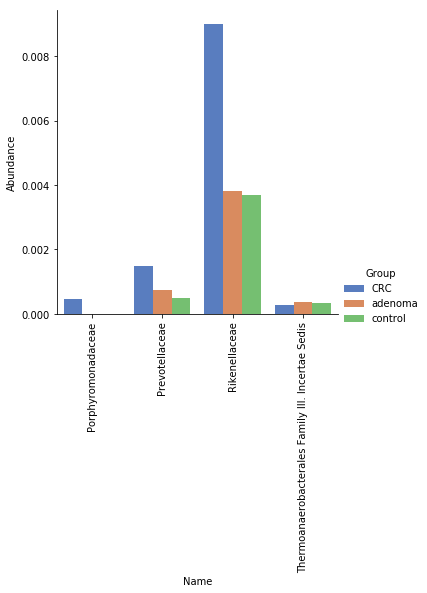

In [161]:
result_df = x[0]
percentile_df = x[1]
differences = list(result_df.loc[result_df["W"] > 10].index)
print("------------------- RESULTS ------------------- ")
df_list = []
for d in differences:
    print(percentile_df[50.0].loc[d])
    df = pd.DataFrame(percentile_df[50.0].loc[d])
    df_list.append(df.transpose())

    df_dataset = pd.concat(df_list)


unpivot = pd.DataFrame(df_dataset.unstack(level=1))
unpivot = unpivot.reset_index()
unpivot["Abundance"] = unpivot[0]
unpivot["Name"] = unpivot['level_1']
unpivot = unpivot.drop(columns=[0, 'level_1'])

g = sns.catplot(x="Name", y="Abundance", hue="Group", data=unpivot,
            kind="bar", palette="muted")
g.set_xticklabels(rotation=90)

//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1

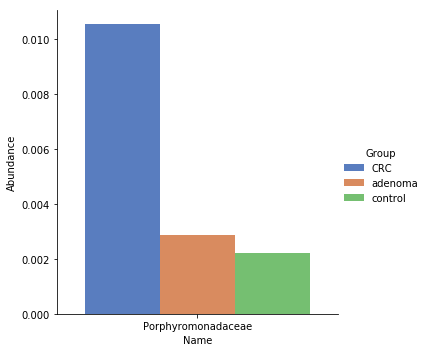

In [163]:
x = df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_metaphlan,
                     column_to_group = "STUDY_CONDITION", rank='f', use_percent = True, percent=30)

In [167]:
result_df.loc[result_df["W"] > 5]

,W,Reject null hypothesis
Name,,
Lactobacillaceae,7,False
Porphyromonadaceae,34,True
Rikenellaceae,7,False


------------------- RESULTS ------------------- 
Group
CRC        0.000400
adenoma    0.000400
control    0.000768
Name: Lactobacillaceae, dtype: float64
Group
CRC        0.010524
adenoma    0.002855
control    0.002226
Name: Porphyromonadaceae, dtype: float64
Group
CRC        0.014762
adenoma    0.006274
control    0.003613
Name: Rikenellaceae, dtype: float64


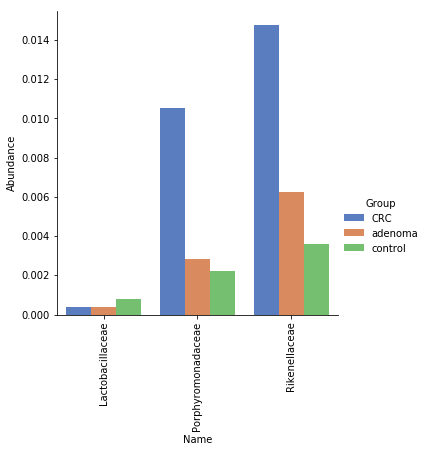

In [168]:
result_df = x[0]
percentile_df = x[1]
differences = list(result_df.loc[result_df["W"] > 5].index)
print("------------------- RESULTS ------------------- ")
df_list = []
for d in differences:
    print(percentile_df[50.0].loc[d])
    df = pd.DataFrame(percentile_df[50.0].loc[d])
    df_list.append(df.transpose())

    df_dataset = pd.concat(df_list)


unpivot = pd.DataFrame(df_dataset.unstack(level=1))
unpivot = unpivot.reset_index()
unpivot["Abundance"] = unpivot[0]
unpivot["Name"] = unpivot['level_1']
unpivot = unpivot.drop(columns=[0, 'level_1'])

g = sns.catplot(x="Name", y="Abundance", hue="Group", data=unpivot,
            kind="bar", palette="muted")
g.set_xticklabels(rotation=90)

//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1

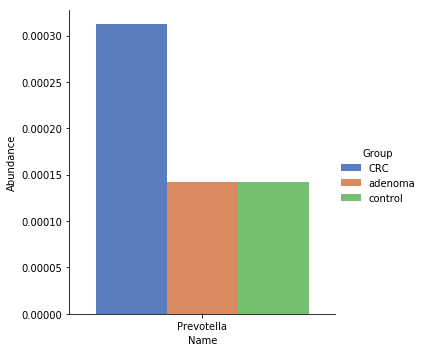

In [169]:
x = df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_metaphlan,
                     column_to_group = "STUDY_CONDITION", rank='g', use_percent = True, percent=30)

In [171]:
result_df = x[0]
percentile_df = x[1]

In [172]:
result_df.loc[result_df["W"] > 5]

,W,Reject null hypothesis
Name,,
Alistipes,9,False
Anaerostipes,8,False
Gemella,9,False
Lachnospiraceae_noname,7,False
Leuconostoc,6,False
Parabacteroides,14,False
Peptostreptococcus,7,False
Porphyromonas,11,False
Prevotella,41,True


------------------- RESULTS ------------------- 
Group
CRC        0.014832
adenoma    0.006310
control    0.003626
Name: Alistipes, dtype: float64
Group
CRC        0.000689
adenoma    0.000898
control    0.001614
Name: Anaerostipes, dtype: float64
Group
CRC        0.000142
adenoma    0.000142
control    0.000142
Name: Gemella, dtype: float64
Group
CRC        0.005920
adenoma    0.008352
control    0.009648
Name: Lachnospiraceae_noname, dtype: float64
Group
CRC        0.000142
adenoma    0.000142
control    0.000142
Name: Leuconostoc, dtype: float64
Group
CRC        0.004593
adenoma    0.000554
control    0.001319
Name: Parabacteroides, dtype: float64
Group
CRC        0.000142
adenoma    0.000142
control    0.000142
Name: Peptostreptococcus, dtype: float64
Group
CRC        0.000142
adenoma    0.000142
control    0.000142
Name: Porphyromonas, dtype: float64
Group
CRC        0.000312
adenoma    0.000142
control    0.000142
Name: Prevotella, dtype: float64
Group
CRC        0.000142
adenoma

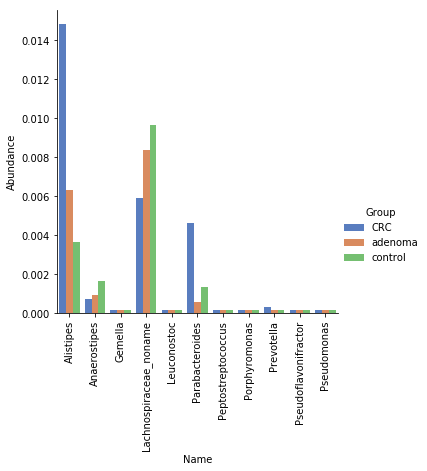

In [173]:
differences = list(result_df.loc[result_df["W"] > 5].index)
print("------------------- RESULTS ------------------- ")
df_list = []
for d in differences:
    print(percentile_df[50.0].loc[d])
    df = pd.DataFrame(percentile_df[50.0].loc[d])
    df_list.append(df.transpose())

    df_dataset = pd.concat(df_list)


unpivot = pd.DataFrame(df_dataset.unstack(level=1))
unpivot = unpivot.reset_index()
unpivot["Abundance"] = unpivot[0]
unpivot["Name"] = unpivot['level_1']
unpivot = unpivot.drop(columns=[0, 'level_1'])

g = sns.catplot(x="Name", y="Abundance", hue="Group", data=unpivot,
            kind="bar", palette="muted")
g.set_xticklabels(rotation=90)

//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank                 Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    U         unclassified      70.88   
1           1  ERR688526  FengQ_2015.csv    R                 root      29.12   
2           2  ERR688526  FengQ_2015.csv   R1   cellular organisms      29.11   
3           3  ERR688526  FengQ_2015.csv    D             Bacteria      29.05   
4           4  ERR688526  FengQ_2015.csv   D1  Terrabacteria group      25.38   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CA

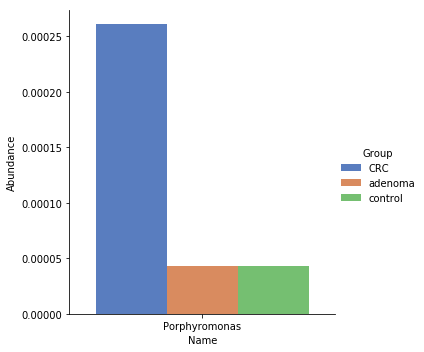

In [175]:
x = df_dataset_ChngKR_2016_kraken = analyse("FengQ_2015", table_files = files_kraken,
                     column_to_group = "STUDY_CONDITION", rank='G', use_percent = True, percent=10)

In [176]:
result_df = x[0]
percentile_df = x[1]

In [178]:
result_df.loc[result_df["W"] > 10]

,W,Reject null hypothesis
Name,,
Alistipes,13,False
Bacteroides,13,False
Blautia,19,False
Faecalitalea,11,False
Fusobacterium,11,False
Gemella,100,False
Odoribacter,26,False
Parvimonas,109,False
Porphyromonas,134,True


------------------- RESULTS ------------------- 
Group
CRC        0.000043
adenoma    0.000043
control    0.000043
Name: Achromobacter, dtype: float64
Group
CRC        0.011301
adenoma    0.004473
control    0.004423
Name: Alistipes, dtype: float64
Group
CRC        0.025085
adenoma    0.069258
control    0.071181
Name: Anaerostipes, dtype: float64
Group
CRC        0.142414
adenoma    0.047330
control    0.043708
Name: Bacteroides, dtype: float64
Group
CRC        0.007041
adenoma    0.013658
control    0.013438
Name: Blautia, dtype: float64
Group
CRC        0.001311
adenoma    0.002509
control    0.002026
Name: Butyrivibrio, dtype: float64
Group
CRC        0.000043
adenoma    0.000043
control    0.000043
Name: Capnocytophaga, dtype: float64
Group
CRC        0.000380
adenoma    0.000509
control    0.000558
Name: Christensenella, dtype: float64
Group
CRC        0.008524
adenoma    0.010935
control    0.010515
Name: Clostridioides, dtype: float64
Group
CRC        0.000043
adenoma    0.0000

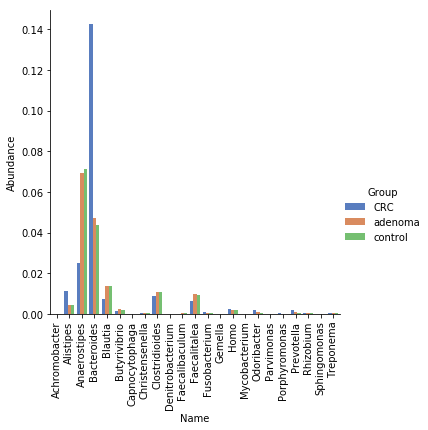

In [179]:
differences = list(result_df.loc[result_df["W"] > 5].index)
print("------------------- RESULTS ------------------- ")
df_list = []
for d in differences:
    print(percentile_df[50.0].loc[d])
    df = pd.DataFrame(percentile_df[50.0].loc[d])
    df_list.append(df.transpose())

    df_dataset = pd.concat(df_list)


unpivot = pd.DataFrame(df_dataset.unstack(level=1))
unpivot = unpivot.reset_index()
unpivot["Abundance"] = unpivot[0]
unpivot["Name"] = unpivot['level_1']
unpivot = unpivot.drop(columns=[0, 'level_1'])

g = sns.catplot(x="Name", y="Abundance", hue="Group", data=unpivot,
            kind="bar", palette="muted")
g.set_xticklabels(rotation=90)

In [133]:
t1 = pd.DataFrame([[12, 11, 10, 0, 10, 0, 0],
                       [9,  11, 12, 10, 10, 10, 10],
                       [1,  11, 0, 11, 10, 5,  9],
                       [22, 21, 9,  0, 10, 10, 10],
                       [20, 22, 0, 10, 13, 10, 10],
                       [23, 21, 14, 10, 10, 10, 10]],
                      index=['s1','s2','s3','s4','s5','s6'],
                      columns=['b1','b2','b3','b4','b5','b6','b7'])
    


In [122]:
t1

,b1,b2,b3,b4,b5,b6,b7
s1,12,11,10,10,10,10,10
s2,9,11,12,10,10,10,10
s3,1,11,10,11,10,5,9
s4,22,21,9,10,10,10,10
s5,20,22,10,10,13,10,10
s6,23,21,14,10,10,10,10


In [123]:
t1.index

Index(['s1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

In [124]:
t1.columns

Index(['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7'], dtype='object')

In [126]:
t1.values

array([[12, 11, 10, 10, 10, 10, 10],
       [ 9, 11, 12, 10, 10, 10, 10],
       [ 1, 11, 10, 11, 10,  5,  9],
       [22, 21,  9, 10, 10, 10, 10],
       [20, 22, 10, 10, 13, 10, 10],
       [23, 21, 14, 10, 10, 10, 10]])

In [130]:
t2 = multiplicative_replacement(t1.values)

In [131]:
t2

array([[0.26198386, 0.24015187, 0.21831989, 0.02040816, 0.21831989,
        0.02040816, 0.02040816],
       [0.125     , 0.15277778, 0.16666667, 0.13888889, 0.13888889,
        0.13888889, 0.13888889],
       [0.02084238, 0.22926617, 0.02040816, 0.22926617, 0.2084238 ,
        0.1042119 , 0.18758142],
       [0.26281732, 0.25087108, 0.10751618, 0.02040816, 0.11946242,
        0.11946242, 0.11946242],
       [0.2304922 , 0.25354142, 0.02040816, 0.1152461 , 0.14981993,
        0.1152461 , 0.1152461 ],
       [0.23469388, 0.21428571, 0.14285714, 0.10204082, 0.10204082,
        0.10204082, 0.10204082]])

In [136]:
t3 = pd.DataFrame(multiplicative_replacement(t1.values),
                      index=t1.index,
                      columns=t1.columns)
    


In [135]:
t3

,b1,b2,b3,b4,b5,b6,b7
s1,0.261984,0.240152,0.218320,0.020408,0.218320,0.020408,0.020408
s2,0.125000,0.152778,0.166667,0.138889,0.138889,0.138889,0.138889
s3,0.020842,0.229266,0.020408,0.229266,0.208424,0.104212,0.187581
s4,0.262817,0.250871,0.107516,0.020408,0.119462,0.119462,0.119462
s5,0.230492,0.253541,0.020408,0.115246,0.149820,0.115246,0.115246
s6,0.234694,0.214286,0.142857,0.102041,0.102041,0.102041,0.102041


# From this point should not be considered

In [259]:
df = get_data_for_sample("//gfs/data/curated_metagenomes_metaphlan2/ChngKR_2016.csv")

In [286]:
def analyse_2(dataset_name, table_files, column_to_group = "STUDY_CONDITION", rank='F'):
    result_df, percentile_df = get_table_and_grouping(dataset_name, table_files,
                                                  column_to_group,
                                                  rank)
    differences = list(result_df.loc[[i for i in result_df["Reject null hypothesis"]]].index)
    print("------------------- RESULTS ------------------- ")
    df_list = []
    
    differences = ['Nocardioidaceae', 'Methylobacteriaceae', 'Malasseziaceae', 'Potyviridae']
    
    for d in differences:
        print(percentile_df[50.0].loc[d])
        df = pd.DataFrame(percentile_df[50.0].loc[d])
        df_list.append(df.transpose())
    try:
        df_dataset = pd.concat(df_list)
    except:
        return differences
    unpivot = pd.DataFrame(df_dataset.unstack(level=1))
    unpivot = unpivot.reset_index()
    unpivot["Abundance"] = unpivot[0]
    unpivot["Name"] = unpivot['level_1']
    unpivot = unpivot.drop(columns=[0, 'level_1'])
    
    g = sns.catplot(x="Name", y="Abundance", hue="Group", data=unpivot,
                kind="bar", palette="muted")
    return unpivot

In [265]:
df.loc[df["Rank"] == "f"][["SUBJECTID", "DISEASE"]].drop_duplicates()

,SUBJECTID,DISEASE
35,Sub1,none
218,Sub6,none
376,Sub5,none
634,Sub12,none
818,Sub4,none
1008,Sub3,none
1255,Sub2,none
2820,Sub7,none


In [267]:
df_k = get_data_for_sample("//gfs/data/curated_metagenomes_kraken2/ChngKR_2016.csv")

In [ ]:
df_k.loc[df_k["Rank"] == "F"][["SUBJECTID", "DISEASE"]].drop_duplicates()

//gfs/data/curated_metagenomes_metaphlan2/ChngKR_2016.csv
   Unnamed: 0   Sample_ID          Dataset Rank            Name  Abundance  \
0           0  SRR1950714  ChngKR_2016.csv    k        Bacteria   89.43953   
1           1  SRR1950714  ChngKR_2016.csv    k         Viruses    9.57920   
2           2  SRR1950714  ChngKR_2016.csv    k       Eukaryota    0.98127   
3           3  SRR1950714  ChngKR_2016.csv    p  Actinobacteria   68.52375   
4           4  SRR1950714  ChngKR_2016.csv    p  Proteobacteria   10.80472   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY DISEASE  AGE AGE_CATEGORY  
0         control      skin      Sub1     IDN    none   30        adult  
1         control      skin      Sub1     IDN    none   30        adult  
2         control      skin      Sub1     IDN    none   30        adult  
3         control      skin      Sub1     IDN    none   30        adult  
4         control      skin      Sub1     IDN    none   30        adult  
Groups: 3                none

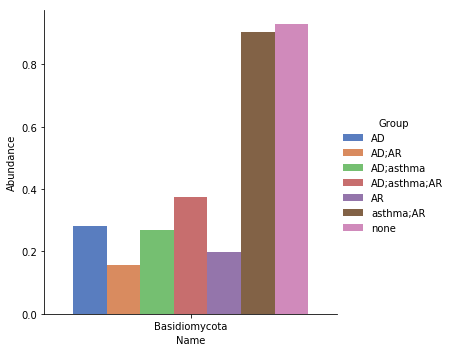

In [292]:
df_dataset_ChngKR_2016_kraken = analyse("ChngKR_2016", table_files = files_metaphlan,
                     column_to_group = "DISEASE", rank='g')

In [306]:
df_datasetAsnicarF_2017_kraken = analyse("AsnicarF_2017", table_files = files_kraken, 
                     column_to_group = "AGE_CATEGORY", rank='P')

//gfs/data/curated_metagenomes_kraken2/AsnicarF_2017.csv
   Unnamed: 0   Sample_ID            Dataset Rank                Name  \
0           0  SRR4052021  AsnicarF_2017.csv    U        unclassified   
1           1  SRR4052021  AsnicarF_2017.csv    R                root   
2           2  SRR4052021  AsnicarF_2017.csv   R1  cellular organisms   
3           3  SRR4052021  AsnicarF_2017.csv    D            Bacteria   
4           4  SRR4052021  AsnicarF_2017.csv    P      Proteobacteria   

   Abundance STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY  DISEASE  AGE  \
0       6.83         control     stool   MV_FEI1     ITA  healthy  1.0   
1      93.17         control     stool   MV_FEI1     ITA  healthy  1.0   
2      91.83         control     stool   MV_FEI1     ITA  healthy  1.0   
3      91.83         control     stool   MV_FEI1     ITA  healthy  1.0   
4      80.22         control     stool   MV_FEI1     ITA  healthy  1.0   

  AGE_CATEGORY  
0      newborn  
1      newborn  
2      n

//gfs/data/curated_metagenomes_metaphlan2/AsnicarF_2017.csv
   Unnamed: 0   Sample_ID            Dataset Rank            Name  Abundance  \
0           0  SRR4052021  AsnicarF_2017.csv    k        Bacteria   97.92389   
1           1  SRR4052021  AsnicarF_2017.csv    k         Viruses    2.07611   
2           2  SRR4052021  AsnicarF_2017.csv    p  Proteobacteria   78.59277   
3           3  SRR4052021  AsnicarF_2017.csv    p  Actinobacteria   12.60032   
4           4  SRR4052021  AsnicarF_2017.csv    p      Firmicutes    6.73081   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY  DISEASE  AGE AGE_CATEGORY  
0         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
1         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
2         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
3         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
4         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
Groups: 2

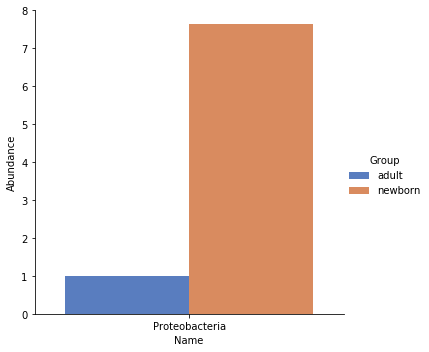

In [309]:
df_datasetAsnicarF_2017_kraken = analyse("AsnicarF_2017", table_files = files_metaphlan, 
                     column_to_group = "AGE_CATEGORY", rank='p')

//gfs/data/curated_metagenomes_metaphlan2/AsnicarF_2017.csv
   Unnamed: 0   Sample_ID            Dataset Rank            Name  Abundance  \
0           0  SRR4052021  AsnicarF_2017.csv    k        Bacteria   97.92389   
1           1  SRR4052021  AsnicarF_2017.csv    k         Viruses    2.07611   
2           2  SRR4052021  AsnicarF_2017.csv    p  Proteobacteria   78.59277   
3           3  SRR4052021  AsnicarF_2017.csv    p  Actinobacteria   12.60032   
4           4  SRR4052021  AsnicarF_2017.csv    p      Firmicutes    6.73081   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY  DISEASE  AGE AGE_CATEGORY  
0         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
1         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
2         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
3         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
4         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
Groups: 2

,Group,Abundance,Name
0,adult,1.000000,Enterobacteriaceae
1,newborn,4.505245,Enterobacteriaceae


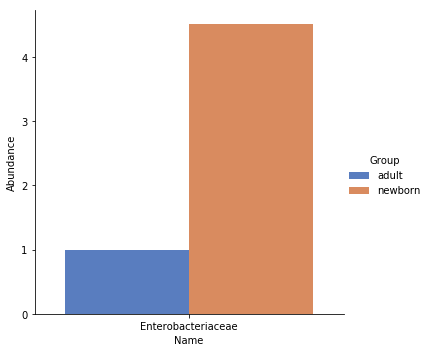

In [248]:
analyse("AsnicarF_2017", table_files = files_metaphlan, column_to_group = "AGE_CATEGORY", 
        rank='f')

//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank                 Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    U         unclassified      70.88   
1           1  ERR688526  FengQ_2015.csv    R                 root      29.12   
2           2  ERR688526  FengQ_2015.csv   R1   cellular organisms      29.11   
3           3  ERR688526  FengQ_2015.csv    D             Bacteria      29.05   
4           4  ERR688526  FengQ_2015.csv   D1  Terrabacteria group      25.38   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CA

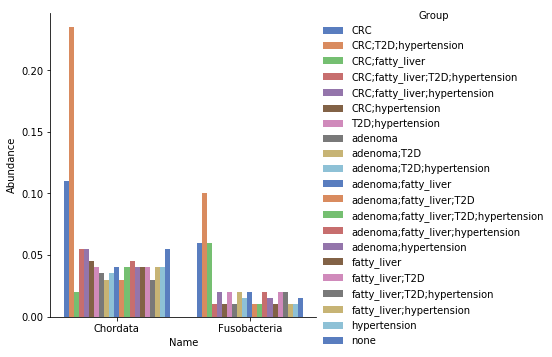

In [294]:
df_datasetAsnicarF_2017_kraken = analyse("FengQ_2015", table_files = files_kraken, 
                     column_to_group = "DISEASE", rank='P')

In [253]:
df_datasetAsnicarF_2017_kraken = analyse("FengQ_2015", table_files = files_kraken, 
                     column_to_group = "STUDY_CONDITION", rank='F')

//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv
   Unnamed: 0  Sample_ID         Dataset Rank                       Name  \
0           0  ERR688526  FengQ_2015.csv    U               unclassified   
1           1  ERR688526  FengQ_2015.csv    R                       root   
2           2  ERR688526  FengQ_2015.csv   R1         cellular organisms   
3           3  ERR688526  FengQ_2015.csv    D                   Bacteria   
4           4  ERR688526  FengQ_2015.csv   D1        Terrabacteria group   

   Abundance STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  \
0      70.88         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   
1      29.12         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   
2      29.11         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   
3      29.05         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   
4      25.38         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   

  